In [50]:
import pandas as pd
import numpy as np

In [51]:
# 加载数据
from firefin.data.gateway import fetch_data
data = fetch_data(['market_cap', 'return_adj', 'pb_ratio','open','close','volume'])
rf = pd.read_feather(r'C:\Users\m1309\Downloads\bond_data\bond_data\us_bond_2y.feather')

D:\PycharmProjects\fire_project\firefin\data\gateway.py:81: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(obj)
D:\PycharmProjects\fire_project\firefin\data\gateway.py:81: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(obj)


In [52]:
#把数据截取成想要的大小，并构造基本的指标如无风险利率，市净率等
mkt_cap = data['market_cap'].iloc[50:670, :300]

ret_adj = data['return_adj'].iloc[50:670, :300]

pb = data['pb_ratio'].iloc[50:670, :300]

open_price = data['open'].iloc[50:700, :300]

dates = mkt_cap.index
stock_code = mkt_cap.columns

bm = 1 / pb


#得到与 mkt_cap、ret_adj 索引一致的 risk_free_rate
if 'datetime' in rf.columns:
    rf['datetime'] = pd.to_datetime(rf['datetime'])
    rf = rf.set_index('datetime')
else:
    rf.index = pd.to_datetime(rf.index)
rf = rf['us_bond_2y']
rf.index = rf.index.normalize()
rf = rf.reindex(dates.normalize(), method='ffill') / 100
rf.index = dates
risk_free_rate = rf

#构造超额收益
excess_ret = ret_adj.sub(risk_free_rate, axis=0).fillna(0)

#构造动量信号
mom_signal = (data["close"] / data["close"].shift(21) -1).shift(1).iloc[50:670, :300]
#mom_signal=mom_signal.drop(columns=["000166.SZ", "000333.SZ"])

In [53]:
#用当期收益率ret_adj构造新的（学术）因子，比如这里就是直接用pb进行打分然后构造多空组合(这里收益统一用字典，key是0表示当天的收益，value是T * quantiles的DataFrame)
return_adjusted = {}
return_adjusted[0]= ret_adj
from firefin.core.algorithm.portfolio_sort import PortfolioSort
pb_quantile_ret = PortfolioSort.single_sort(factor=pb, forward_returns=return_adjusted, quantiles=5, market_cap = mkt_cap)


In [54]:
#提取H-L这一项，将它作为后续检验的开始
pb_HML = [pb_quantile_ret[0].iloc[:,1]]

In [55]:
# 学术因子的检测，本项目里面有基础的AcaEvaluatorModel用来做学术因子对于收益率的检验
from firefin.evaluation.academia.AcaEvaluatorModel import *
basic_test = AcaEvaluatorModel(factor_portfolio=pb_HML,return_adj=excess_ret,time_series_window=None,cov_type="HAC")

In [56]:
#对该因子进行时序回归，返回因子暴露、截距、残差以及各种统计量
basic_test.run_time_series_regression()

BatchRegressionResult(
 alpha:
    stock_code           000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  \
    datetime                                                                     
    2009-03-23 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2009-03-24 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2009-03-25 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2009-03-26 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2009-03-27 15:00:00        NaN        NaN        NaN        NaN        NaN   
    ...                        ...        ...        ...        ...        ...   
    2011-09-26 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2011-09-27 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2011-09-28 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2011-09-29 15:00:00        NaN        NaN        NaN        NaN

In [57]:
#进行横截面回归，返回因子暴露在横截面上的性质，返回回归系数，回归截距，残差以及t统计量
basic_test.run_cross_sectional_regression()

BatchRegressionResult(
 alpha:
    datetime
    2009-03-23 15:00:00         NaN
    2009-03-24 15:00:00         NaN
    2009-03-25 15:00:00         NaN
    2009-03-26 15:00:00         NaN
    2009-03-27 15:00:00         NaN
                             ...   
    2011-09-26 15:00:00         NaN
    2011-09-27 15:00:00         NaN
    2011-09-28 15:00:00         NaN
    2011-09-29 15:00:00         NaN
    2011-09-30 15:00:00   -0.003824
    Name: alpha, Length: 620, dtype: float64,
 alpha_t:
    datetime
    2009-03-23 15:00:00         NaN
    2009-03-24 15:00:00         NaN
    2009-03-25 15:00:00         NaN
    2009-03-26 15:00:00         NaN
    2009-03-27 15:00:00         NaN
                             ...   
    2011-09-26 15:00:00         NaN
    2011-09-27 15:00:00         NaN
    2011-09-28 15:00:00         NaN
    2011-09-29 15:00:00         NaN
    2011-09-30 15:00:00   -3.168131
    Name: alpha_t, Length: 620, dtype: float64,
 beta:
                                0
    da

In [58]:
#进行fama macbeth回归，得到横截面上的性质，返回回归系数，回归截距，t统计量
#basic_test.run_fama_macbeth_regression()

In [59]:
from firefin.evaluation.academia.AcaIndirectEvaluator import *
pb_HML_indirect_test = AcaIndirectEvaluator(factor_portfolio=pb_HML, return_adj=ret_adj, risk_free_rate=risk_free_rate,
                         stock_size=mkt_cap, stock_value=bm, mom_signal=mom_signal)

<Axes: title={'center': 'grs p value'}, xlabel='time', ylabel='grs p value'>

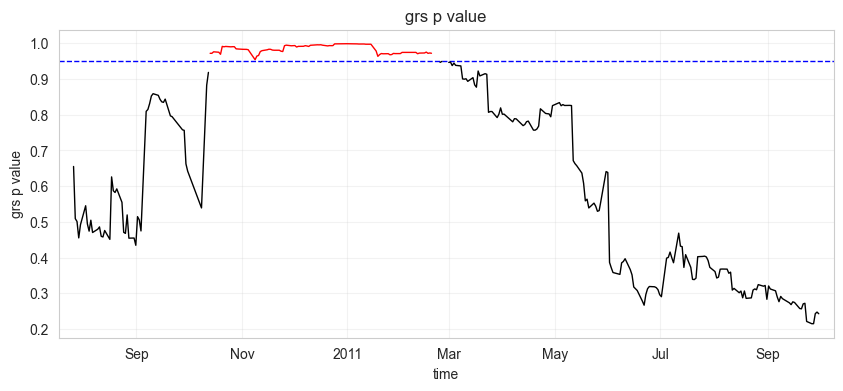

In [61]:
pb_HML_indirect_test.evaluate_stability(mode = "ff3_mom",window = 330)

In [62]:
# 对于pb这个指标我们可以对它的每一个分位数的性质都做检验，先构造分位收益率
quantile_ret = [pb_quantile_ret[0][col] for col in pb_quantile_ret[0].columns]

In [63]:
# 学术因子的检测，本项目里面有基础的AcaEvaluatorModel用来做学术因子对于收益率的检验
from firefin.evaluation.academia.AcaIndirectEvaluator import *

indirect_test = AcaIndirectEvaluator(factor_portfolio=quantile_ret, return_adj=ret_adj, risk_free_rate=risk_free_rate,
                         stock_size=mkt_cap, stock_value=bm, mom_signal=mom_signal)


In [64]:
# 构造对于每一个分位数检验的LaTex表格
indirect_test.export_evaluation_table()

D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:151: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_last = float(res.alpha.iloc[-1])
D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:156: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_t_last = float(res.alpha_t.iloc[-1])
D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:151: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_last = float(res.alpha.iloc[-1])
D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:156: FutureWarning: Calling float on a single element Series is deprecated and will raise a T

'\\toprule\n\\begin{tabular}{l c c c c c c c c c c c}\nPortfolio & \\multicolumn{2}{c}{Excess Return} & \\multicolumn{3}{c}{CAPM} & \\multicolumn{6}{c}{4-Factor} \\\\\n\\cmidrule(lr){2-3}\\cmidrule(lr){4-6}\\cmidrule(lr){7-12}\n & mean daily excess\\_ret & std & alpha & MKT & Adj \\$R\\textasciicircum{}2\\$ & alpha & MKT & SMB & HML & MOM & Adj \\$R\\textasciicircum{}2\\$ \\\\\n\\midrule\n1 & -0.007 & 0.017 & \\begin{tabular}[t]{@{}r@{}}0.01\\\\(19.77)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}0.93\\\\(53.81)\\end{tabular} & 0.824 & \\begin{tabular}[t]{@{}r@{}}0.01\\\\(24.84)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}0.83\\\\(54.73)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}0.01\\\\(0.37)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}0.51\\\\(16.44)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}-0.08\\\\(-3.61)\\end{tabular} & 0.886 \\\\\n2 & -0.007 & 0.018 & \\begin{tabular}[t]{@{}r@{}}0.01\\\\(22.40)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}0.98\\\\(57.37)\\end{tabular} & 0.842 

In [65]:
indirect_test.evaluate_by_other_factors(mode = "capm")

D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:151: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_last = float(res.alpha.iloc[-1])
D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:156: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_t_last = float(res.alpha_t.iloc[-1])


(        alpha       MKT
 1    0.006035  0.929609
 2    0.006741  0.977219
 3    0.007683  1.012424
 4    0.008605  1.035336
 5    0.010524  0.912341
 H-L  0.004489 -0.017268,
          alpha        MKT
 1    19.773786  53.814823
 2    22.398316  57.365660
 3    26.040536  60.628173
 4    25.113490  53.385369
 5     6.382559   9.775840
 H-L   2.644378  -0.179721,
 1      0.823849
 2      0.841640
 3      0.855838
 4      0.821511
 5      0.132527
 H-L   -0.001566
 Name: r2_adj, dtype: float64)

D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:297: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_i = float(res.alpha.iloc[-1])


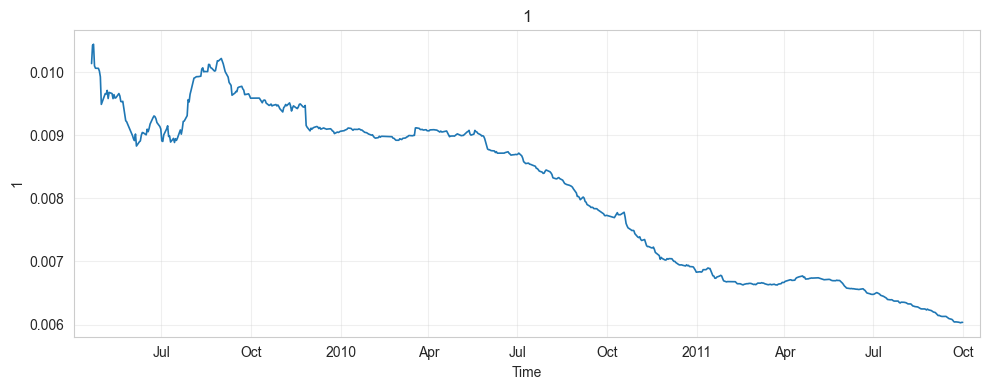

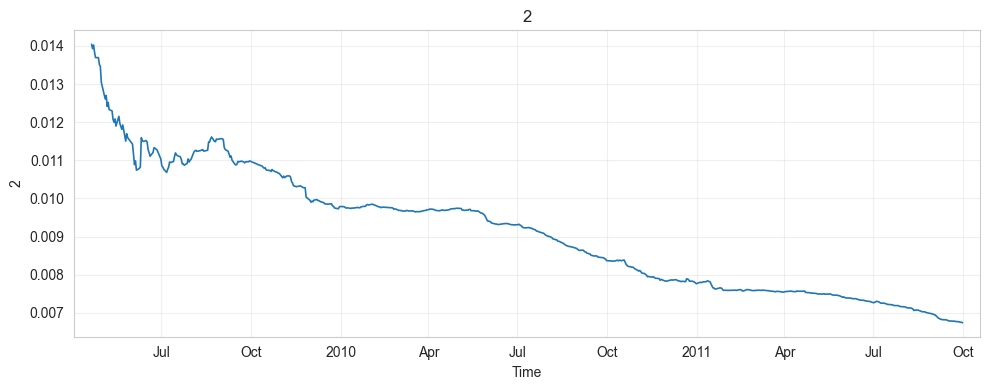

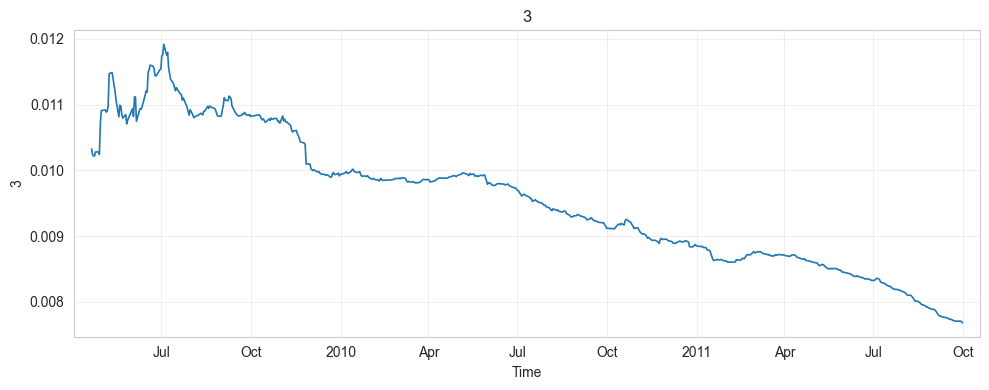

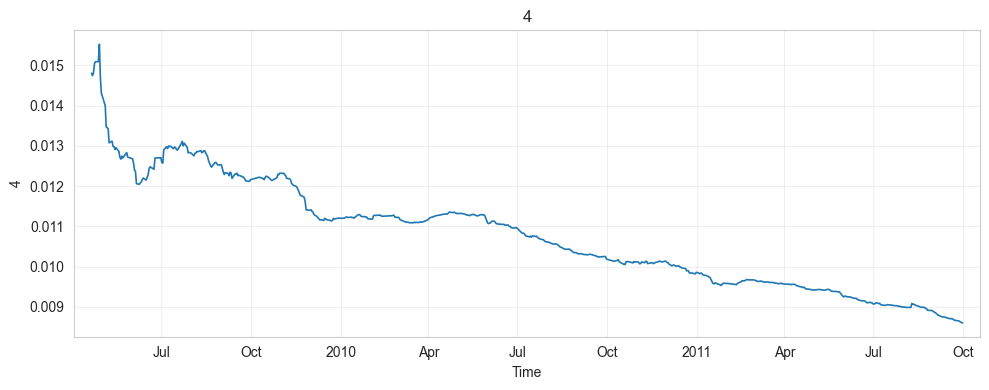

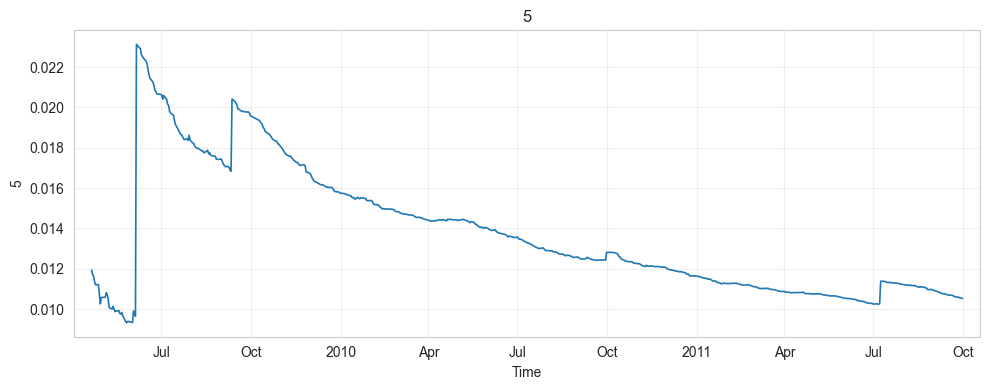

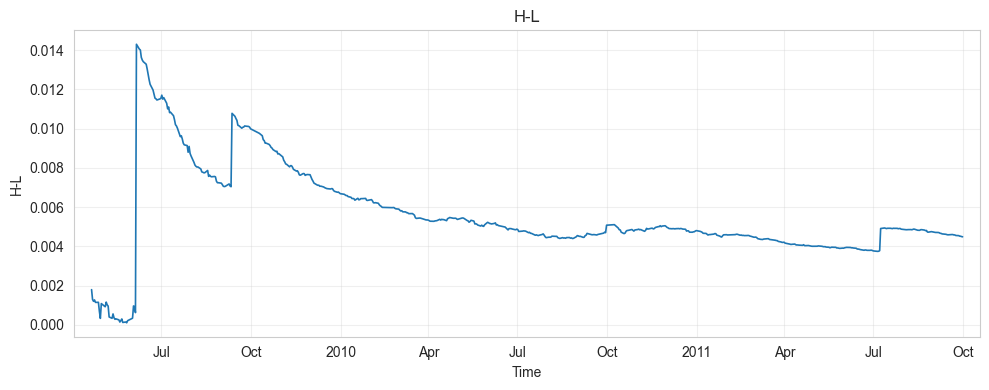

In [66]:
indirect_test.cumulated_alpha(mode = "capm")

In [67]:
# 项目提供了非常简便构造经典学术因子的函数，例如fama french 3因子
from firefin.evaluation.academia.AcademicFactors import *
ff3 = bundle_ff3(stock_return = ret_adj,
    size = mkt_cap,
    book_to_market = bm,
    market_cap = mkt_cap,
    risk_free_rate = risk_free_rate)

In [68]:
# 本项目提供了独立的做横截面回归的函数，可以输出回归系数以及检验指标，不需要走AcaEvaluator的流程了
from firefin.core.algorithm.cross_sectional_regression import *
res=cross_sectional_regression(ff3, excess_ret,cov_type="HAC",window=50)

In [69]:
# 本项目提供了单独的fama macbeth回归，返回回归系数的值以及其检验统计量，不需要走AcaEvaluator的流程了
from firefin.core.algorithm.fama_macbeth import *
rr=FamaMacBeth.run_regression(ff3, excess_ret,window=50)

In [70]:
#本项目提供一个封装好的RollingRegressor类，可以设定滚动窗口，得到时序axis=0,或截面axis=1的回归结果以及数据的检验统计量。
window = 120
ff3_factor = np.stack([f.values.reshape(-1, 1) for f in ff3], axis=0)
maxlag=int(4*(window/100)**(2/9))
from firefin.core.algorithm.regression import *
result = RollingRegressor(
    x = ff3_factor,
    y = excess_ret,
).fit(window=120,cov_type="HAC",cov_kwds={"maxlags": maxlag})


In [71]:
# newey west t 检验，检验回归系数是否显著为0
from firefin.core.algorithm.newey_west_t_statistics import NeweyWestTest
NeweyWestTest.newey_west_t_test(result, ff3)

D:\PycharmProjects\fire_project\firefin\core\algorithm\newey_west_t_statistics.py:75: RuntimeWarning: invalid value encountered in divide
  t_values = beta_vec / se


{Timestamp('2009-09-10 15:00:00'):                 alpha        MKT       SMB       HML
 stock_code                                          
 000001.SZ   -0.921270   3.084399 -2.895297  2.661742
 000002.SZ    0.393068  14.726817 -3.913624  0.630565
 000004.SZ    0.447846  14.739955  4.018913 -5.964701
 000005.SZ    0.511238  14.394799  2.369178  1.097056
 000006.SZ    0.268782   7.860687 -2.667370 -0.050327
 ...               ...        ...       ...       ...
 000748.SZ    0.604795   8.845041  4.334469 -2.039006
 000750.SZ  -30.596586   1.206820 -1.529334  0.398987
 000751.SZ   -1.647234  11.197618  0.241737 -0.622408
 000752.SZ    1.324749   8.465386  4.052486  0.115433
 000753.SZ    0.769641  11.648564  1.551282  2.066121
 
 [300 rows x 4 columns],
 Timestamp('2009-09-11 15:00:00'):                 alpha        MKT       SMB       HML
 stock_code                                          
 000001.SZ   -0.775775   3.293226 -2.900465  2.343885
 000002.SZ    0.195202  14.879065 -3.8796